<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/Vega_Ferrero_v_Petr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd

В текущей задаче интеграл, которому равна вероятность для отдельной модели, будет выглядеть так: $$P(H_0|D) \propto P(H_0) \int d \Delta t \ d \mu \cdot p_{lens} (\Delta t, \mu|H_0) \cdot p_{obs} (\Delta t, \mu)$$

where (1) $P(H_0)$ is the prior for $H_0$, 

(2) $p_{lens}(∆t, \mu)$ is the distribution of time delay and magnification predictions of a given lens model (which can be re-scaled to any alternative value of H0), and 

(3) $p_{obs}(∆t, \mu)$ is the ‘observational’ distribution obtained in this work. 

We assume that for each lens model, $p_{lens}(∆t, \mu)$ is described with a normal bivariate distribution (with no correlation between $∆t$ and $\mu$). The mean values and their statistical uncertainties for each image are taken from Table 6 of Treu et al.(2016). Using this approach, we cannot utilize measurements for four images S1-S4 at once to constrain the Hubble parameter, since these images are not independent. Thus, we concentrate on the S2 image as the image with the tightest constraints on the time delay (relative to S1; see Table 4). We include also the SX image since it’s largely independent from S2, even though published data on SX light curve are not enough to place tight constraints. The obtained $P(H_0|D)$ for both S2 and SX for considered here lens models are shown in Figure 12.

Note that in fact the lens models do not contribute equally to the average
posterior distribution. Models with magnification predictions which disagree with our best-fit values are actually down-weighted (see eq. 1). А каким образом?

Contributions of the lens model predictions to $P_+(H0|D)$ obtained as a product of $$p_{lens,i}(∆t_{S2}, \mu_{S2}|H0) \times p_{lens,i}(∆t_{SX}, \mu_{SX}|H0)$$ are shown in Figure 12 (left panel).


Определим несимметричную гауссиану и нормируем её (внимание, возможно, придётся менять пределы интегрирования при подсчёте площади):

In [0]:
def nonsym_gauss(x, mean, sigma_left, sigma_right):       #поточечно
    
    pdf = 0
        
    if x >= mean:
        pdf = np.exp( - (x - mean)**2/2/sigma_right**2 )
    else:
        pdf = np.exp( - (x - mean)**2/2/sigma_left**2 )
    
    area_left  =  integrate.quad(lambda t: np.exp( - (t - mean)**2/2/sigma_left**2 ), 0,    mean)
    area_right =  integrate.quad(lambda t: np.exp( - (t - mean)**2/2/sigma_right**2 ), mean, 1000)
    
    area = area_left[0] + area_right[0]
    
    return pdf/area 

Запишем временную задержку и усиление SX/S1 и S2/S1 из наблюдательных данных (нескоррелированных) в модели Петра:

In [0]:
dt_X1_data =             [315.3] #среднее
sigma_right_dt_X1_data = [59.4] #погрешность справа
sigma_left_dt_X1_data =  [84.1] #погрешность слева

mu_X1_data =             [0.2 ] 
sigma_right_mu_X1_data = [0.13] 
sigma_left_mu_X1_data =  [0.06] 

dt_21_data =             [9.6] 
sigma_right_dt_21_data = [2.0] 
sigma_left_dt_21_data =  [2.2] 

mu_21_data =             [1.14] 
sigma_right_mu_21_data = [0.02] 
sigma_left_mu_21_data =  [0.02] 

Данные моделей из Treu et al.(2015):

In [0]:
names =  ['Gri-g',   'Ogu-g', 'Ogu-a', 'Sha-a', 'Sha-g']
colors = ['orange',  'blue',  'green', 'black', 'indigo']

dt_X1_model =             [361, 311, 336, 233, 277] #среднее
sigma_right_dt_X1_model = [ 19,  24,  21,  46,  11] #погрешность справа
sigma_left_dt_X1_model =  [ 27,  24,  21,  13,  21] #погрешность слева

mu_X1_model =             [0.36, 0.27, 0.27, 0.19, 0.25] 
sigma_right_mu_X1_model = [0.11, 0.05, 0.03, 0.01, 0.05] 
sigma_left_mu_X1_model =  [0.09, 0.05, 0.03, 0.04, 0.02] 

dt_21_model =             [10.6,  8.7,  9.4,  8,  6] 
sigma_right_dt_21_model = [ 6.2,  0.7,  1.1,  7,  6] 
sigma_left_dt_21_model =  [ 3.0,  0.7,  1.1,  5,  5] 

mu_21_model =             [0.92, 1.14, 1.15, 0.84, 0.84] 
sigma_right_mu_21_model = [0.43, 0.24, 0.17, 0.20, 0.18] 
sigma_left_mu_21_model =  [0.52, 0.24, 0.17, 0.19, 0.06] 

Проинтегрируем всё вместе (я тут добавил простенький прогрессбар):

In [0]:
#from tqdm import tqdm #модуль, иллюстрирующий прогресс

H_0_fid = 70. #km/s/Mpc
H_0s = np.linspace(30, 150, 31)

PDFs = np.zeros((len(names), len(H_0s)))

for i in range(0, len(names)):

    P_prom = []
        
    for j in range(0, len(H_0s)):#, desc=names[i]):
        
        P_H_0 = 1./len(H_0s)

        # x - время, y - усиление
        
        int = integrate.nquad(lambda x, y: nonsym_gauss(x, dt_21_data[0], sigma_left_dt_21_data[0], sigma_right_dt_21_data[0]) *   #наблюдательные данные
                                           
                                nonsym_gauss(y, mu_21_data[0], sigma_left_mu_21_data[0], sigma_right_mu_21_data[0]) * 
                              
                                nonsym_gauss(x, (H_0_fid/H_0s[j])*dt_21_model[i],                              #данные из моделей
                                             sigma_left_dt_21_model[i], sigma_right_dt_21_model[i]) *
                              
                                nonsym_gauss(y, mu_21_model[i], 
                                             sigma_left_mu_21_model[i], sigma_right_mu_21_model[i]),
                                
                                [[0, 500], [0, 1]] )
        
        
        print(names[i], round(j/len(H_0s), 2), 'H_0 = ', H_0s[j], 'int =', int[0])

        PDFs[i][j] = P_H_0 * int[0]


import pandas as pd

spisok = pd.DataFrame(PDFs).to_csv('Petr_21_PDFs.csv', index=False)

from google.colab import files

files.download('Petr_21_PDFs.csv')

Gri-g 0.0 H_0 =  30.0 int = 1.506450595527187e-17
Gri-g 0.03 H_0 =  34.0 int = 1.3535438214347902e-16
Gri-g 0.06 H_0 =  38.0 int = 6.684285550928344e-16
Gri-g 0.1 H_0 =  42.0 int = 3.1756864835438468e-15
Gri-g 0.13 H_0 =  46.0 int = 1.14596990937665e-14
Gri-g 0.16 H_0 =  50.0 int = 2.9412655330407896e-14
Gri-g 0.19 H_0 =  54.0 int = 5.754886309779525e-14
Gri-g 0.23 H_0 =  58.0 int = 9.250925801272519e-14
Gri-g 0.26 H_0 =  62.0 int = 1.2912143056593953e-13
Gri-g 0.29 H_0 =  66.0 int = 1.6269504244625107e-13
Gri-g 0.32 H_0 =  70.0 int = 1.9020705664333556e-13
Gri-g 0.35 H_0 =  74.0 int = 2.104053766885445e-13
Gri-g 0.39 H_0 =  78.0 int = 2.2336487618773044e-13


Сохраним полученные значения в файл (если работа осуществляется не из google colab, то надо закомментить последние две строчки):

In [0]:
import pandas as pd

spisok = pd.DataFrame(PDFs).to_csv('Petr_21_PDFs.csv', index=False)

from google.colab import files

files.download('Petr_21_PDFs.csv')

Подгрузим старые значения (если они уже есть):

In [25]:
uploaded = files.upload()

Saving Petr_X1_PDFs.csv to Petr_X1_PDFs (1).csv


In [0]:
data = pd.read_csv('Petr_21_PDFs.csv').to_numpy()

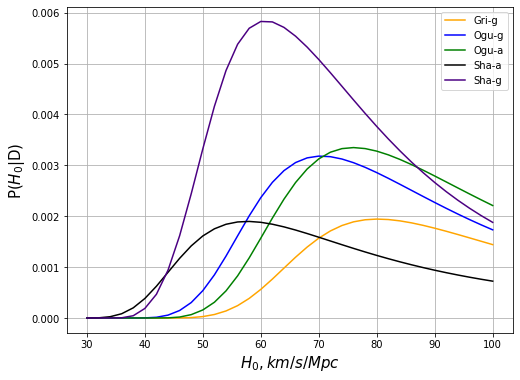

In [29]:
fig = plt.figure(figsize=(8,6))

for i in range(0, len(names)):

    plt.plot(H_0s, data[i][0:], label = names[i], color=colors[i])
    plt.legend()
    plt.xlabel('$H_0, km/s/Mpc$', fontsize=15)
    plt.ylabel('P($H_0$|D)', fontsize=15)

#plt.axvline(H_0s[np.argmax(PDFs[-1])], color='black', linestyle='--')    
plt.grid()
plt.show()

Определим функцию, которая возвращает индексы элементов, соответствующих границам интервала в 68%, вдоль горизонтальной оси:

In [0]:
def f1sb(xs, distribution, percents, plot, Print): #find 1 sigma borders
    
    area = sum(distribution)*np.diff(xs)[0]
    pdf = distribution/area
    cdf = np.cumsum(pdf)*np.diff(H_0s)[0]
    
    leftb_perc = (1-percents)/2.
    rightb_perc = 1-leftb_perc
    
    left_ind = np.argmin(np.abs(cdf - leftb_perc))
    right_ind = np.argmin( np.abs(cdf - rightb_perc) )
    middle_ind = np.argmin( np.abs(cdf - .5) )
    
    if plot == True:
        
        plt.plot(H_0s, cdf, 'r:')
        
        plt.axhline(leftb_perc,color='m')
        plt.axhline(rightb_perc,color='m')

        plt.axvline(H_0s[left_ind],color='g')
        plt.axvline(H_0s[right_ind],color='g')
        plt.axvline(H_0s[middle_ind],color='g')
    
    if Print == True:
        print('Mean: H_0=', H_0s[middle_ind])
        print('Left border: H_0=', H_0s[left_ind])
        print('Right border: H_0=', H_0s[right_ind])
        print('Left sigma =', H_0s[middle_ind] - H_0s[left_ind])
        print('Right sigma =', H_0s[right_ind] - H_0s[middle_ind])

    return H_0s[middle_ind], H_0s[middle_ind] - H_0s[left_ind], H_0s[right_ind] - H_0s[middle_ind]

Отдельно перемножим и сложим получившиеся вероятности:

In [54]:
P_mult = np.ones(len(H_0s))
P_sum = np.zeros(len(H_0s))

for i in range(0, len(names)):
    #print(P_mult)
    P_mult = data[i] * P_mult
    P_sum = P_sum + data[i]/(len(names))

P_sum_mean, sigma_P_sum_left, sigma_P_sum_right = f1sb(H_0s, P_sum, .68, plot=False, Print=True)

Mean: H_0= 72.0
Left border: H_0= 58.0
Right border: H_0= 90.0
Left sigma = 14.0
Right sigma = 18.0


For P_+(H_0|D):
H_0 = 72.0 + 18.0 - 14.0 (program)
H_0 = 71.2 + 16.7 - 11.6 (Petr)


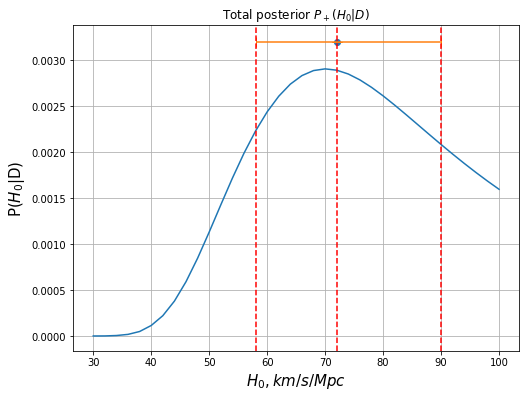

In [57]:
print('For P_+(H_0|D):')
print('H_0 =', P_sum_mean, '+', sigma_P_sum_right, '-', sigma_P_sum_left, '(program)')
print('H_0 = 71.2 + 16.7 - 11.6 (Petr)')

fig = plt.figure(figsize=(8,6))

plt.grid()
plt.xlabel('$H_0, km/s/Mpc$', fontsize=15)
plt.ylabel('P($H_0$|D)', fontsize=15)
plt.title('Total posterior $P_+(H_0|D)$')

plt.plot(H_0s, P_sum)#, label = '$P_+(H_0|D)$', linestyle='--')
plt.scatter(P_sum_mean, 1.1*P_sum[np.argmax(P_sum)])
plt.errorbar(P_sum_mean, 1.1*P_sum[np.argmax(P_sum)], 0, [[sigma_P_sum_left], [sigma_P_sum_right]], capsize=5)

plt.axvline(P_sum_mean - sigma_P_sum_left, linestyle = '--',  color = 'r')
plt.axvline(P_sum_mean, linestyle = '--',  color = 'r')
plt.axvline(P_sum_mean + sigma_P_sum_right, linestyle = '--',  color = 'r')

plt.show()